In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.metrics as sm 
import time
from tqdm import tqdm
from timeit import default_timer as timer
import time
import warnings
warnings.filterwarnings('ignore')

C:\Users\shant\.conda\envs\amex\lib\site-packages\pyarrow\compute.py:198: RuntimeWarning: Python binding for CumulativeSumOptions not exposed
  .format(class_name), RuntimeWarning)
C:\Users\shant\.conda\envs\amex\lib\site-packages\pyarrow\compute.py:198: RuntimeWarning: Python binding for RankOptions not exposed
  .format(class_name), RuntimeWarning)


In [69]:
def read_parquet(path='', cols=None):
    """
        Returns pandas dataframe

        Parameters
        -----------
        path to training data in parquet format

        Returns
        ----------
        Pandas DataFrame

        """
    # LOAD DATAFRAME
    if cols is not None:
        dataFrame = pd.read_parquet(path, columns=cols)
    else:
        dataFrame = pd.read_parquet(path)

    
    dataFrame['customer_ID'] = dataFrame['customer_ID'].str[-16:].apply(int, base=16).astype('int64')
    dataFrame.S_2 = pd.to_datetime(dataFrame.S_2)

    
    dataFrame = dataFrame.fillna(-127)
    print('shape of data:', dataFrame.shape)

    return dataFrame


print('Reading train data...')
TRAIN_PATH = 'train.parquet'
train = read_parquet(path=TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [ ]:
def feature_engineering(df):
    """
    :param df: pandas dataframe of train dataset
    :return: feature engineered data
    
    """
    all_col_of_df = [c for c in list(df.columns) if c not in ['customer_ID', 'S_2']]
    cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]
    num_features = [col for col in all_col_of_df if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape)

    return df


train = feature_engineering(train)


In [ ]:
# ADD TARGETS
output_var = pd.read_csv('C:/Users/shant/Downloads/train_labels.csv')
output_var['customer_ID'] = output_var['customer_ID'].str[-16:].apply(int, base=16).astype('int64')
output_var = output_var.set_index('customer_ID')
train = train.merge(output_var, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del output_var


train = train.sort_index().reset_index()

# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

In [ ]:
shape_before_remove = train.shape[0]
train = train.dropna()
print('Number of records removed: ',abs(shape_before_remove - train.shape[0]))
print('% of customers removed from data: ', round(abs(shape_before_remove - train.shape[0]) * 100 /shape_before_remove,2))

In [ ]:
train.isna().sum()[train.isna().sum() !=0]

### Train Test Split

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[FEATURES], train['target'], test_size=0.3)

### PCA

In [45]:
# Need to standardize data before PCA is performed as sklearn doesn't standardize data.
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()

scaler_train.fit(X_train)
X_train_std = pd.DataFrame(scaler_train.transform(X_train))

scaler_test = StandardScaler()
scaler_test.fit(X_test)
X_test_std = pd.DataFrame(scaler_test.transform(X_test))

In [46]:
def generalized_variance(X, normalize=True):
    cov = np.cov(X, rowvar=False)
    if normalize:
        return np.linalg.det(cov) / np.trace(cov)
    else:
        return np.linalg.det(cov)

GV = generalized_variance(X_train_std.copy(), True) # Lower values are better
GV

0.0

Text(0, 0.5, '% of variance explained')

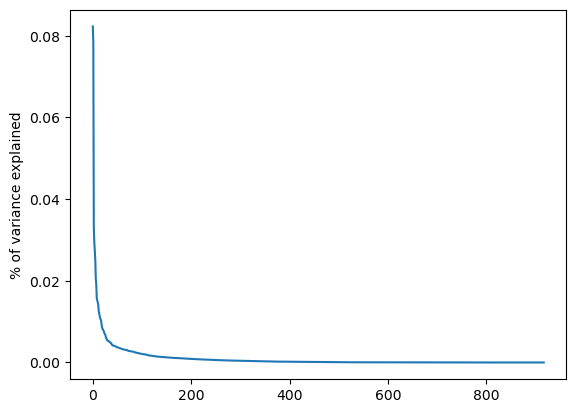

In [48]:
## PCA decomposition
pca = PCA(n_components=X_train.shape[1]) #Finds first leading PCs
pca.fit(X_train_std)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('% of variance explained')
#plot reaches asymptote at around 80, which is optimal number of PCs to use. 

In [55]:
n_pcs = 200
print(pca.explained_variance_ratio_[:n_pcs].sum())

0.8939721818039615


In [50]:
def de_correlate_df(df):
        
    X_aux = df.copy()
    for col in df.columns:
        X_aux[col] = df[col].sample(len(df)).values
        
    return X_aux

In [51]:
pca = PCA()
pca.fit(X_train_std)
original_variance = pca.explained_variance_ratio_

In [52]:
N_permutations = 100
variance = np.zeros((N_permutations, len(X_train_std.columns)))

In [53]:
import plotly.graph_objects as go
p_val = np.sum(variance > original_variance, axis=0) / N_permutations
fig = go.Figure()
fig.add_trace(go.Scatter(x=[f'PC{i}' for i in range(len(X_train.columns))], y=p_val, name='p-value on significance'))
fig.update_layout(title="PCA Permutation Test p-values")

### Artificial Neural Network

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier


optimizer = 'adam'
activation_function = 'relu'
hidden_layer_neurons = (5,5,8,7,9,5)
learning_rate = 0.001
learning_rate_schedule = 'adaptive'

clf = MLPClassifier(solver=optimizer, alpha=1e-5,
                    activation=activation_function,
                    hidden_layer_sizes=hidden_layer_neurons,
                    learning_rate_init=learning_rate,
                    learning_rate = learning_rate_schedule)

# nn_clf_1 = clf.fit(X_train, y_train)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
lst_accu_stratified = []

start = timer() 
    
for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    clf.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(clf.score(x_test_fold, y_test_fold))
  
print('Training time: ', round(timer() - start /60, 2), '\mins')

Training time:  22422.9 	mins


In [33]:
# Print the output.
print('List of possible accuracy:\n\n', lst_accu_stratified)
print(f'\n Model = \n \
    \n optimizer = {optimizer}, \
    \n activation function for hidden layers = {activation_function}, \
    \n Neurons in each hidden layer = {hidden_layer_neurons}, \
    \n learning_rate = {learning_rate}, \
    \n learning_rate_schedule = {learning_rate_schedule} \
    \n number of iters = {clf.n_iter_}, \
    \n activation function for output layer = {clf.out_activation_} ' ) 
print(f'\nMaximum Accuracy That can be obtained from this model is:',max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:', min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:', np.mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(lst_accu_stratified))

List of possible accuracy:

 [0.887094489304434, 0.88813335222175, 0.8873935559018432, 0.890494404306559, 0.8895499834726354]

 Model = 
     
 optimizer = sgd,     
 activation function for hidden layers = relu,     
 Neurons in each hidden layer = (5, 5, 8, 7, 9, 5),     
 learning_rate = 0.001,     
 learning_rate_schedule = adaptive     
 number of iters = 200,     
 activation function for output layer = logistic 

Maximum Accuracy That can be obtained from this model is: 89.0494404306559 %

Minimum Accuracy: 88.7094489304434 %

Overall Accuracy: 88.85331570414444 %

Standard Deviation is: 0.0012968212162695247


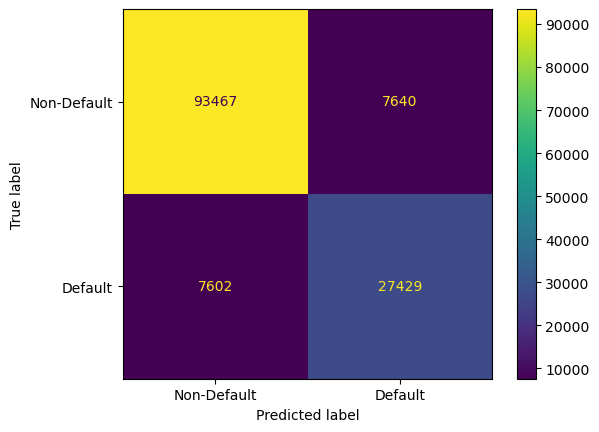

In [34]:
# X_test = X_test.drop(columns=corr_features, axis=1)
sm.plot_confusion_matrix(clf, X_test, y_test, display_labels=['Non-Default', 'Default'])

In [35]:
# X_test = X_test.drop(columns=corr_features, axis=1)
y_pred = clf.predict(X_test)

# Import Classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92    101107
           1       0.78      0.78      0.78     35031

    accuracy                           0.89    136138
   macro avg       0.85      0.85      0.85    136138
weighted avg       0.89      0.89      0.89    136138



-----------